# dataset

> Module to load and preprocess the NuScenes dataset.

In [ ]:
#| default_exp dataset

In [ ]:
#|export
import numpy as np
from torch.utils.data import Dataset
from pathlib import Path
import os
import json
import operator
import itertools
import pickle
import numba
from pyquaternion import Quaternion

from nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from nuscenes.eval.detection.config import config_factory
from nuscenes.eval.detection.evaluate import NuScenesEval

In [ ]:
#|eval: false
#|hide
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [ ]:
#|exports
@numba.njit
def points_in_boxes_jit(points: np.ndarray, # Float array [N, *]
                        boxes: np.ndarray, # Float array [M, 7] or [M, 9], with first 6 dimensions x, y, z, length, width, height, last dimension yaw angle
                        indices: np.ndarray # Bool array of shape [N, M]
                        ): # Bool array of shape [N, M]
    """This function determines if points are within a set of 3D boxes."""
    num_points = points.shape[0]
    num_boxes = boxes.shape[0]
    for j in range(num_boxes):
        for i in range(num_points):
            if np.abs(points[i, 2] - boxes[j, 2]) <= boxes[j, 5] / 2.0:
                cosa = np.cos(boxes[j, -1])
                sina = np.sin(boxes[j, -1])
                shift_x = points[i, 0] - boxes[j, 0]
                shift_y = points[i, 1] - boxes[j, 1]
                local_x = shift_x * cosa + shift_y * sina
                local_y = -shift_x * sina + shift_y * cosa
                indices[i, j] = np.logical_and(np.abs(local_x) <= boxes[j, 3] / 2.0,
                                               np.abs(local_y) <= boxes[j, 4] / 2.0)

In [ ]:
#|exports
def points_in_rbbox(points: np.ndarray, # Float array [N, *]
                    boxes: np.ndarray # Float array [M, 7] or [M, 9], with first 6 dimensions x, y, z, length, width, height, last dimension yaw angle
                    ): # Bool array of shape [N, M]
    """This function determines if points are within a set of rotated 3D boxes and returns a boolean array indicating the results."""
    indices = np.zeros((points.shape[0], boxes.shape[0]), dtype=bool) # Bool array of shape [N, M]
    points_in_boxes_jit(points, boxes, indices)
    return indices

In [ ]:
#| eval: false
# Test Data
points = np.array([
    [1.0, 1.0, 1.0],
    [2.0, 2.0, 2.0],
    [3.0, 3.0, 3.0]
])

boxes = np.array([
    [1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 0.0],  # Box centered at (1,1,1) with length=2, width=2, height=2, no rotation
    [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, np.pi/4]  # Box centered at (2,2,2) with length=2, width=2, height=2, rotated 45 degrees
])

# Expected output: array of shape (3, 2)
# For each point, we check if it is within each of the two boxes
indices = points_in_rbbox(points, boxes)

print("Points:\n", points)
print("\nBoxes:\n", boxes)
print("\nIndices (Points in Boxes):\n", indices)

Points:
 [[1. 1. 1.]
 [2. 2. 2.]
 [3. 3. 3.]]

Boxes:
 [[1.         1.         1.         2.         2.         2.
  0.        ]
 [2.         2.         2.         2.         2.         2.
  0.78539816]]

Indices (Points in Boxes):
 [[ True False]
 [ True  True]
 [False False]]


In [ ]:
#|eval: false
#|hide
def plot_boxes(ax, boxes):
    """Plot 3D boxes on a matplotlib axis."""
    for box in boxes:
        x, y, z, l, w, h, yaw = box[:7]
        cosa = np.cos(yaw)
        sina = np.sin(yaw)
        # Define the 8 corners of the box
        corners = np.array([
            [x + l/2 * cosa - w/2 * sina, y + l/2 * sina + w/2 * cosa, z - h/2],
            [x + l/2 * cosa + w/2 * sina, y + l/2 * sina - w/2 * cosa, z - h/2],
            [x - l/2 * cosa + w/2 * sina, y - l/2 * sina - w/2 * cosa, z - h/2],
            [x - l/2 * cosa - w/2 * sina, y - l/2 * sina + w/2 * cosa, z - h/2],
            [x + l/2 * cosa - w/2 * sina, y + l/2 * sina + w/2 * cosa, z + h/2],
            [x + l/2 * cosa + w/2 * sina, y + l/2 * sina - w/2 * cosa, z + h/2],
            [x - l/2 * cosa + w/2 * sina, y - l/2 * sina - w/2 * cosa, z + h/2],
            [x - l/2 * cosa - w/2 * sina, y - l/2 * sina + w/2 * cosa, z + h/2]
        ])
        # Define the 12 edges of the box
        edges = [
            [corners[i] for i in [0, 1, 5, 4]],
            [corners[i] for i in [1, 2, 6, 5]],
            [corners[i] for i in [2, 3, 7, 6]],
            [corners[i] for i in [3, 0, 4, 7]],
            [corners[i] for i in [0, 1, 2, 3]],
            [corners[i] for i in [4, 5, 6, 7]]
        ]
        # Plot each face of the box
        for edge in edges:
            ax.add_collection3d(Poly3DCollection([edge], facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))


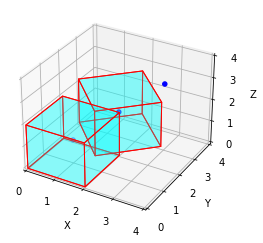

In [ ]:
#|eval: false
# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='blue', marker='o')

# Plot boxes
plot_boxes(ax, boxes)

# Set plot labels and limits
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.set_zlim(0, 4)

plt.show()

In [ ]:
#|exports
class BaseDataset(Dataset):
    """An abstract class representing a pytorch-like Dataset.
    All other datasets should subclass it. All subclasses should override
    ``__getitem__`` supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __init__(
            self,
            root_path, # Root path of the dataset
            info_path, # Path to the info file
            sampler=None, # Sampler for sampling data
            loading_pipelines=None, # Loading pipelines
            augmentation=None, # Augmentation pipelines
            prepare_label=None, # Prepare label pipelines
            evaluations=None, # Evaluation pipelines
            create_database=False, # Whether to create database
            use_gt_sampling=True # Whether to use ground truth sampling
            ):

        self._info_path = info_path
        self._root_path = Path(root_path)
        self.loading_pipelines = loading_pipelines
        self.augmentations = augmentation
        self.prepare_label = prepare_label
        self.evaluations = evaluations
        self.create_database = create_database
        self.use_gt_sampling = use_gt_sampling
        self.load_infos()
        if use_gt_sampling and sampler is not None:
            self.sampler = sampler()
        else:
            self.sampler = None

    def __len__(self):
        return len(self.infos)

    def load_infos(self):
        with open(os.path.join(self._root_path, self._info_path), "rb") as f:
            self.infos = pickle.load(f)

    def evaluation(self):
        """Dataset must provide a evaluation function to evaluate model."""
        # support different evaluation tasks
        raise NotImplementedError

    def load_pointcloud(self, res, info):
        raise NotImplementedError

    def load_box3d(self, res, info):
        res["annotations"] = {
            'gt_boxes': info["gt_boxes"].astype(np.float32).copy(),
            'gt_names': np.array(info["gt_names"]).reshape(-1).copy(),
        }

        return res

    def __getitem__(self, idx):

        info = self.infos[idx]
        res = {"token": info["token"]}

        if self.loading_pipelines is not None:
            for lp in self.loading_pipelines:
                res = getattr(self, lp)(res, info)
        if self.sampler is not None:
            sampled_dict = self.sampler.sample_all(
                res['annotations']['gt_boxes'],
                res["annotations"]['gt_names']
            )
            if sampled_dict is not None:
                sampled_gt_names = sampled_dict["gt_names"]
                sampled_gt_boxes = sampled_dict["gt_boxes"]
                sampled_points = sampled_dict["points"]
                sampled_gt_masks = sampled_dict["gt_masks"]
                res['annotations']["gt_names"] = np.concatenate(
                    [res['annotations']["gt_names"], sampled_gt_names], axis=0
                )
                res['annotations']["gt_boxes"] = np.concatenate(
                    [res['annotations']["gt_boxes"], sampled_gt_boxes]
                )

                # remove points in sampled gt boxes
                sampled_point_indices = points_in_rbbox(
                    res['points'], sampled_gt_boxes[sampled_gt_masks])
                res['points'] = res['points'][np.logical_not(
                    sampled_point_indices.any(-1))]

                res['points'] = np.concatenate(
                    [sampled_points, res['points']], axis=0)
        if self.augmentations is not None:
            for aug in self.augmentations.values():
                res = aug(res)

        if self.prepare_label is not None:
            for _, pl in self.prepare_label.items():
                res = pl(res)

        if 'annotations' in res and (not self.create_database):
            del res['annotations']

        return res

    def format_eval(self):
        raise NotImplementedError

In [ ]:
#|export
def _second_det_to_nusc_box(detection):
    """
    Convert a detection output from a second model to nuScenes box format.
    
    Args:
        detection (dict): A dictionary containing detection outputs with keys:
                          - "box3d_lidar": 3D bounding boxes in LiDAR coordinates.
                          - "scores": Confidence scores of the detections.
                          - "label_preds": Predicted labels for the detections.
    
    Returns:
        list: A list of nuScenes Box objects.
    """
    box3d = detection["box3d_lidar"].detach().cpu().numpy()
    scores = detection["scores"].detach().cpu().numpy()
    labels = detection["label_preds"].detach().cpu().numpy()
    box3d = box3d[:, [0, 1, 2, 4, 3, 5, 6, 7, 8]]
    box_list = []
    for i in range(box3d.shape[0]):
        quat = Quaternion(axis=[0, 0, 1], radians=box3d[i, -1])
        velocity = (*box3d[i, 6:8], 0.0)
        box = Box(
            box3d[i, :3],
            box3d[i, 3:6],
            quat,
            label=labels[i],
            score=scores[i],
            velocity=velocity,
        )
        box_list.append(box)
    return box_list

In [ ]:
#|export
def _lidar_nusc_box_to_global(nusc, boxes, sample_token):
    """
    Transform nuScenes boxes from the LiDAR coordinate system to the global coordinate system.
    
    Args:
        nusc (NuScenes): The nuScenes dataset object.
        boxes (list): A list of nuScenes Box objects.
        sample_token (str): The sample token for the current frame.
    
    Returns:
        list: A list of transformed nuScenes Box objects in the global coordinate system.
    """
    try:
        s_record = nusc.get("sample", sample_token)
        sample_data_token = s_record["data"]["LIDAR_TOP"]
    except:
        sample_data_token = sample_token

    sd_record = nusc.get("sample_data", sample_data_token)
    cs_record = nusc.get("calibrated_sensor",
                         sd_record["calibrated_sensor_token"])
    pose_record = nusc.get("ego_pose", sd_record["ego_pose_token"])

    box_list = []
    for box in boxes:
        # Move box to ego vehicle coord system
        box.rotate(Quaternion(cs_record["rotation"]))
        box.translate(np.array(cs_record["translation"]))
        # Move box to global coord system
        box.rotate(Quaternion(pose_record["rotation"]))
        box.translate(np.array(pose_record["translation"]))
        box_list.append(box)
    return box_list

In [ ]:
#|eval: false
#|hide
# Mock detection input data
detection = {
    "box3d_lidar": torch.tensor([
        [1, 2, 3, 1.5, 2.5, 1.0, 0.1, 0.2, np.pi/4]
    ]),
    "scores": torch.tensor([0.9]),
    "label_preds": torch.tensor([1])
}

# Mock nusc object with necessary methods
class MockNusc:
    def get(self, table_name, token):
        if table_name == "sample":
            return {
                "data": {
                    "LIDAR_TOP": "lidar_top_token"
                }
            }
        elif table_name == "sample_data":
            return {
                "calibrated_sensor_token": "calibrated_sensor_token",
                "ego_pose_token": "ego_pose_token"
            }
        elif table_name == "calibrated_sensor":
            return {
                "rotation": [0, 0, 0, 1],
                "translation": [0, 0, 0]
            }
        elif table_name == "ego_pose":
            return {
                "rotation": [0, 0, 0, 1],
                "translation": [0, 0, 0]
            }
        else:
            return None

nusc = MockNusc()

# Test _second_det_to_nusc_box function
boxes = _second_det_to_nusc_box(detection)
print("Boxes from _second_det_to_nusc_box:")
for box in boxes:
    print(vars(box))

# Test _lidar_nusc_box_to_global function
sample_token = "sample_token"
global_boxes = _lidar_nusc_box_to_global(nusc, boxes, sample_token)
print("\nGlobal Boxes from _lidar_nusc_box_to_global:")
for box in global_boxes:
    print(vars(box))

Boxes from _second_det_to_nusc_box:
{'center': array([1., 2., 3.], dtype=float32), 'wlh': array([2.5, 1.5, 1. ], dtype=float32), 'orientation': Quaternion(0.9238795283293805, 0.0, 0.0, 0.38268344246110436), 'label': 1, 'score': 0.8999999761581421, 'velocity': array([0.1, 0.2, 0. ]), 'name': None, 'token': None}

Global Boxes from _lidar_nusc_box_to_global:
{'center': array([1., 2., 3.]), 'wlh': array([2.5, 1.5, 1. ], dtype=float32), 'orientation': Quaternion(-0.9238795283293805, 0.0, 0.0, -0.38268344246110436), 'label': 1, 'score': 0.8999999761581421, 'velocity': array([0.1, 0.2, 0. ]), 'name': None, 'token': None}


In [ ]:
#|export
#|hide
# Class attribute distribution
cls_attr_dist = {
    "barrier": {
        "cycle.with_rider": 0,
        "cycle.without_rider": 0,
        "pedestrian.moving": 0,
        "pedestrian.sitting_lying_down": 0,
        "pedestrian.standing": 0,
        "vehicle.moving": 0,
        "vehicle.parked": 0,
        "vehicle.stopped": 0,
    },
    "bicycle": {
        "cycle.with_rider": 2791,
        "cycle.without_rider": 8946,
        "pedestrian.moving": 0,
        "pedestrian.sitting_lying_down": 0,
        "pedestrian.standing": 0,
        "vehicle.moving": 0,
        "vehicle.parked": 0,
        "vehicle.stopped": 0,
    },
    "bus": {
        "cycle.with_rider": 0,
        "cycle.without_rider": 0,
        "pedestrian.moving": 0,
        "pedestrian.sitting_lying_down": 0,
        "pedestrian.standing": 0,
        "vehicle.moving": 9092,
        "vehicle.parked": 3294,
        "vehicle.stopped": 3881,
    },
    "car": {
        "cycle.with_rider": 0,
        "cycle.without_rider": 0,
        "pedestrian.moving": 0,
        "pedestrian.sitting_lying_down": 0,
        "pedestrian.standing": 0,
        "vehicle.moving": 114304,
        "vehicle.parked": 330133,
        "vehicle.stopped": 46898,
    },
    "construction_vehicle": {
        "cycle.with_rider": 0,
        "cycle.without_rider": 0,
        "pedestrian.moving": 0,
        "pedestrian.sitting_lying_down": 0,
        "pedestrian.standing": 0,
        "vehicle.moving": 882,
        "vehicle.parked": 11549,
        "vehicle.stopped": 2102,
    },
    "ignore": {
        "cycle.with_rider": 307,
        "cycle.without_rider": 73,
        "pedestrian.moving": 0,
        "pedestrian.sitting_lying_down": 0,
        "pedestrian.standing": 0,
        "vehicle.moving": 165,
        "vehicle.parked": 400,
        "vehicle.stopped": 102,
    },
    "motorcycle": {
        "cycle.with_rider": 4233,
        "cycle.without_rider": 8326,
        "pedestrian.moving": 0,
        "pedestrian.sitting_lying_down": 0,
        "pedestrian.standing": 0,
        "vehicle.moving": 0,
        "vehicle.parked": 0,
        "vehicle.stopped": 0,
    },
    "pedestrian": {
        "cycle.with_rider": 0,
        "cycle.without_rider": 0,
        "pedestrian.moving": 157444,
        "pedestrian.sitting_lying_down": 13939,
        "pedestrian.standing": 46530,
        "vehicle.moving": 0,
        "vehicle.parked": 0,
        "vehicle.stopped": 0,
    },
    "traffic_cone": {
        "cycle.with_rider": 0,
        "cycle.without_rider": 0,
        "pedestrian.moving": 0,
        "pedestrian.sitting_lying_down": 0,
        "pedestrian.standing": 0,
        "vehicle.moving": 0,
        "vehicle.parked": 0,
        "vehicle.stopped": 0,
    },
    "trailer": {
        "cycle.with_rider": 0,
        "cycle.without_rider": 0,
        "pedestrian.moving": 0,
        "pedestrian.sitting_lying_down": 0,
        "pedestrian.standing": 0,
        "vehicle.moving": 3421,
        "vehicle.parked": 19224,
        "vehicle.stopped": 1895,
    },
    "truck": {
        "cycle.with_rider": 0,
        "cycle.without_rider": 0,
        "pedestrian.moving": 0,
        "pedestrian.sitting_lying_down": 0,
        "pedestrian.standing": 0,
        "vehicle.moving": 21339,
        "vehicle.parked": 55626,
        "vehicle.stopped": 11097,
    },
}

In [ ]:
#|exports
def eval_main(nusc, # NuScenes dataset object.
              eval_version, # Version of the evaluation configuration to use.
              res_path, # Path to the results file.
              eval_set, # The dataset split to evaluate on (e.g., 'val', 'test').
              output_dir # Directory to store the evaluation results.
              ):

    cfg = config_factory(eval_version)

    nusc_eval = NuScenesEval(
        nusc,
        config=cfg,
        result_path=res_path,
        eval_set=eval_set,
        output_dir=output_dir,
        verbose=True,
    )
    _ = nusc_eval.main(plot_examples=0,)

In [ ]:
#|exports
class NuScenesDataset(BaseDataset): # NuScenes dataset class

    def __init__(self,
                 info_path,  # Path to dataset information file
                 root_path,  # Path to root directory of dataset
                 nsweeps,  # Number of sweeps (LiDAR frames) to use
                 sampler=None,  # Sampler for dataset
                 loading_pipelines=None,  # Loading pipelines for data processing
                 augmentation=None,  # Data augmentation methods
                 prepare_label=None,  # Method for preparing labels
                 class_names=[],  # List of class names
                 resampling=False,  # Whether to resample dataset
                 evaluations=None,  # Evaluation methods
                 create_database=False,  # Whether to create a database
                 use_gt_sampling=True,  # Whether to use ground truth sampling
                 version="v1.0-trainval" # Dataset version
                 ): # NuScenes dataset

        super(NuScenesDataset, self).__init__(
            root_path, info_path, sampler, loading_pipelines, augmentation, prepare_label, evaluations, create_database,
            use_gt_sampling=use_gt_sampling)  # Initialize base class

        self.nsweeps = nsweeps
        assert self.nsweeps > 0, "At least input one sweep please!"  # Ensure at least one sweep is used

        self._class_names = list(itertools.chain(*[t for t in class_names]))  # Flatten class names list
        self.version = version

        if resampling:
            self.cbgs()  # Resample dataset if needed

    def cbgs(self): # Performs class-balanced resampling on the dataset by oversampling underrepresented classes
        _cls_infos = {name: [] for name in self._class_names}  # Initialize dictionary for class info
        for info in self.infos:  # Iterate over dataset information
            for name in set(info["gt_names"]):  # For each unique ground truth name
                if name in self._class_names:
                    _cls_infos[name].append(info)  # Add info to corresponding class

        duplicated_samples = sum([len(v) for _, v in _cls_infos.items()])  # Total number of samples after duplication
        _cls_dist = {k: len(v) / duplicated_samples for k, v in _cls_infos.items()}  # Distribution of classes

        _nusc_infos = []

        frac = 1.0 / len(self._class_names)  # Fraction for resampling
        ratios = [frac / v for v in _cls_dist.values()]  # Calculate resampling ratios

        for cls_infos, ratio in zip(list(_cls_infos.values()), ratios):
            _nusc_infos += np.random.choice(cls_infos, int(len(cls_infos) * ratio)).tolist()  # Resample and add to infos

        self.infos = _nusc_infos  # Update dataset information

    def read_file(self, path, num_point_feature=4): # Reads a point cloud file and returns the points in the specified format
        points = np.fromfile(os.path.join(self._root_path, path),
                             dtype=np.float32).reshape(-1, 5)[:, :num_point_feature]  # Read point cloud file and reshape
        return points  # Return points of shape (N, num_point_feature)

    def read_sweep(self, sweep, min_distance=1.0): # Reads a sweep file, applies transformations, removes points too close to the origin, and returns the points and their timestamps
        points_sweep = self.read_file(str(sweep["lidar_path"])).T  # Read sweep file and transpose, shape (num_point_feature, N)

        nbr_points = points_sweep.shape[1]
        if sweep["transform_matrix"] is not None:
            points_sweep[:3, :] = sweep["transform_matrix"].dot(
                np.vstack((points_sweep[:3, :], np.ones(nbr_points))))[:3, :]  # Apply transformation matrix
        points_sweep = self.remove_close(points_sweep, min_distance)  # Remove points too close to the origin
        curr_times = sweep["time_lag"] * np.ones((1, points_sweep.shape[1]))  # Create current times array

        return points_sweep.T, curr_times.T  # Return points and times of shape (N, num_point_feature), (N, 1)

    @staticmethod
    def remove_close(points, radius: float): # Removes points that are too close to the origin
        """
        Removes point too close within a certain radius from origin.
        :param radius: Radius below which points are removed.
        """
        x_filt = np.abs(points[0, :]) < radius
        y_filt = np.abs(points[1, :]) < radius
        not_close = np.logical_not(np.logical_and(x_filt, y_filt))  # Create filter for points outside the radius
        points = points[:, not_close]  # Apply filter to points
        return points  # Return filtered points

    def load_pointcloud(self, res, info): # Loads a point cloud and its sweeps, concatenating them together with their timestamps

        lidar_path = info["lidar_path"]

        points = self.read_file(str(lidar_path))  # Read point cloud file

        sweep_points_list = [points]  # Initialize sweep points list
        sweep_times_list = [np.zeros((points.shape[0], 1))]  # Initialize sweep times list

        for i in range(len(info["sweeps"])):  # Iterate over sweeps
            sweep = info["sweeps"][i]
            points_sweep, times_sweep = self.read_sweep(sweep)  # Read each sweep
            sweep_points_list.append(points_sweep)  # Add sweep points to list
            sweep_times_list.append(times_sweep)  # Add sweep times to list

        points = np.concatenate(sweep_points_list, axis=0)  # Concatenate all points
        times = np.concatenate(sweep_times_list, axis=0).astype(points.dtype)  # Concatenate all times

        res["points"] = np.hstack([points, times])  # Combine points and times

        return res  # Return updated result

    def evaluation(self, detections, output_dir=None, testset=False): # Evaluates detections against the dataset, calculates metrics, and optionally performs resampling. It returns the results or None if the evaluation is not performed
        version = self.version
        eval_set_map = {
            "v1.0-mini": "mini_val",
            "v1.0-trainval": "val",
            "v1.0-test": "test",
        }

        dets = [v for _, v in detections.items()]  # Get list of detections

        nusc_annos = {
            "results": {},
            "meta": None,
        }

        nusc = NuScenes(version=version, dataroot=str(
            self._root_path), verbose=True)  # Initialize NuScenes dataset

        mapped_class_names = []
        for n in self._class_names:
            mapped_class_names.append(n)  # Map class names

        for det in dets:  # Iterate over detections
            annos = []
            boxes = _second_det_to_nusc_box(det) # Convert detection to NuScenes box format
            boxes = _lidar_nusc_box_to_global(nusc, boxes, det["token"]) # Convert lidar boxes to global coordinates
            for i, box in enumerate(boxes):
                name = mapped_class_names[box.label]
                if np.sqrt(box.velocity[0] ** 2 + box.velocity[1] ** 2) > 0.2:
                    if name in [
                        "car",
                        "construction_vehicle",
                        "bus",
                        "truck",
                        "trailer",
                    ]:
                        attr = "vehicle.moving"
                    elif name in ["bicycle", "motorcycle"]:
                        attr = "cycle.with_rider"
                    else:
                        attr = None
                else:
                    if name in ["pedestrian"]:
                        attr = "pedestrian.standing"
                    elif name in ["bus"]:
                        attr = "vehicle.parked"
                    else:
                        attr = None

                nusc_anno = {
                    "sample_token": det["token"],
                    "translation": box.center.tolist(),  # Box center coordinates
                    "size": box.wlh.tolist(),  # Box size (width, length, height)
                    "rotation": box.orientation.elements.tolist(),  # Box rotation (quaternion)
                    "velocity": box.velocity[:2].tolist(),  # Box velocity (x, y)
                    "detection_name": name,  # Class name
                    "detection_score": box.score,  # Detection score
                    "attribute_name": attr
                    if attr is not None
                    else max(cls_attr_dist[name].items(), key=operator.itemgetter(1))[0],  # Attribute name
                }
                annos.append(nusc_anno)
            nusc_annos["results"].update({det["token"]: annos})  # Add annotations to results

        nusc_annos["meta"] = {
            "use_camera": False,
            "use_lidar": True,
            "use_radar": False,
            "use_map": False,
            "use_external": False,
        }

        name = self._info_path.split("/")[-1].split(".")[0]
        res_path = str(Path(output_dir) / Path(name + ".json"))
        with open(res_path, "w") as f:
            json.dump(nusc_annos, f)  # Save annotations to JSON file

        print(f"Finish generate predictions for testset, save to {res_path}")

        if not testset:
            eval_main(
                nusc,
                "detection_cvpr_2019",
                res_path,
                eval_set_map[self.version],
                output_dir,
            )  # Run evaluation

            with open(Path(output_dir) / "metrics_summary.json", "r") as f:
                metrics = json.load(f)  # Load evaluation metrics

            detail = {}
            result = f"Nusc {version} Evaluation\n"
            for name in mapped_class_names:  # Iterate over class names
                detail[name] = {}
                for k, v in metrics["label_aps"][name].items():  # Iterate over evaluation metrics
                    detail[name][f"dist@{k}"] = v
                threshs = ", ".join(list(metrics["label_aps"][name].keys()))  # Distance thresholds
                scores = list(metrics["label_aps"][name].values())  # Scores
                mean = sum(scores) / len(scores)  # Mean score
                scores = ", ".join([f"{s * 100:.2f}" for s in scores])  # Format scores
                result += f"{name} Nusc dist AP@{threshs}\n"
                result += scores
                result += f" mean AP: {mean}"
                result += "\n"
            res_nusc = {
                "results": {"nusc": result},
                "detail": {"nusc": detail},
            }
        else:
            res_nusc = None

        if res_nusc is not None:
            res = {
                "results": {"nusc": res_nusc["results"]["nusc"], },
                "detail": {"eval.nusc": res_nusc["detail"]["nusc"], },
            }
            return res['results']  # Return results
        else:
            return None  # Return None if no results

In [ ]:
#|eval: false
train_dataset = NuScenesDataset("infos_train_10sweeps_withvelo_filterZero.pkl",
                                "/root/nuscenes-dataset/v1.0-mini",
                                10,
                                class_names=[["car"], ["truck", "construction_vehicle"], ["bus", "trailer"], ["barrier"], ["motorcycle", "bicycle"], ["pedestrian", "traffic_cone"]],
                                resampling=True)

In [ ]:
#|eval: false
# Test cbgs method (performs class-balanced resampling on the dataset by oversampling underrepresented classes)

print("Before resampling:")
for cls_name in train_dataset._class_names:
    print(f"{cls_name}: {sum(1 for info in train_dataset.infos if cls_name in info['gt_names'])}")

train_dataset.cbgs()

print("\nAfter resampling:")
for cls_name in train_dataset._class_names:
    print(f"{cls_name}: {sum(1 for info in train_dataset.infos if cls_name in info['gt_names'])}")

Before resampling:
car: 7350
truck: 5529
construction_vehicle: 6160
bus: 6002
trailer: 1618
barrier: 3350
motorcycle: 3397
bicycle: 3866
pedestrian: 6660
traffic_cone: 5909

After resampling:
car: 49840
truck: 41378
construction_vehicle: 45470
bus: 39848
trailer: 12492
barrier: 26659
motorcycle: 25617
bicycle: 29545
pedestrian: 47074
traffic_cone: 44544


In [ ]:
#|eval: false
# Simulate reading a file
points = train_dataset.read_file("/root/nuscenes-dataset/v1.0-mini/samples/LIDAR_TOP/n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151603547590.pcd.bin")
print(f"Read points: {points.shape}")

Read points: (34752, 4)


In [ ]:
#|eval: false
# Simulate reading a sweep
sweep = {
    "lidar_path": "/root/nuscenes-dataset/v1.0-mini/sweeps/LIDAR_TOP/n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151603597909.pcd.bin",
    "transform_matrix": None,
    "time_lag": 0.1
}
points, times = train_dataset.read_sweep(sweep)
print(f"Read sweep points: {points.shape}, times: {times.shape}")

Read sweep points: (20486, 4), times: (20486, 1)


In [ ]:
#|eval: false
# Simulate loading a pointcloud
info = {
    "lidar_path": "/root/nuscenes-dataset/v1.0-mini/samples/LIDAR_TOP/n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151603547590.pcd.bin",
    "sweeps": [{"lidar_path": "/root/nuscenes-dataset/v1.0-mini/sweeps/LIDAR_TOP/n008-2018-08-01-15-16-36-0400__LIDAR_TOP__1533151603597909.pcd.bin", "transform_matrix": None, "time_lag": 0.1}]
}
res = {}
result = train_dataset.load_pointcloud(res, info)
print(f"Loaded pointcloud: {result['points'].shape}")

Loaded pointcloud: (55238, 5)


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()